In [1]:
%reset-f
%load_ext autoreload
%autoreload 2

In [2]:
from res_ind_lib import *

from sorted_nicely import *
from replace_with_warning import *

import os, time
import warnings
warnings.filterwarnings("always",category=UserWarning)

In [3]:
import numpy as np
import pandas as pd

#Pandas display options
# pd.set_option('display.max_colwidth', 200)
# pd.set_option('display.width', 200)
# pd.set_option('display.precision', 10)
# pd.set_option('display.max_rows', 500)

import matplotlib.pylab as plt
%matplotlib inline
font = {'family' : 'serif',
    'weight' : 'normal',
    'size'   : 15}
plt.rc('font', **font)

In [4]:
economy = "country" #province, deparmtent
event_level = [economy, "hazard", "rp"]

# read 

In [5]:
macro = pd.read_csv("intermediate/macro.csv", index_col=economy).dropna()
macro.sample(n=2)

,gdp_pc_pp,pop,urbanization_rate,prepare_scaleup,borrow_abi,avg_prod_k,T_rebuild_K,pi,income_elast,rho,shareable,max_increased_spending,fa_glofris,protection,tau_tax
country,,,,,,,,,,,,,,,
Mongolia,9132.305704,2839073.0,0.72040,0.533333,0.566667,0.207675,3,0.2,1.5,0.06,0.8,0.05,0.047108,1.0,0.196383
Bangladesh,2853.447740,156594962.0,0.34277,0.733333,0.616667,0.289709,3,0.2,1.5,0.06,0.8,0.05,0.220012,1.0,0.055500


In [6]:
cat_info = pd.read_csv("intermediate/cat_info.csv",  index_col=[economy, "income_cat"]).dropna()
cat_info.sample(n=2)

,,n,c,axfin,gamma_SP,k,fa,v,shew
country,income_cat,,,,,,,,
Tajikistan,nonpoor,0.8,2785.76942,0.004779,1.060961,7391.935367,0.103046,0.125978,0.48
Zambia,nonpoor,0.8,4579.39611,0.176789,1.190069,10772.494495,0.008479,0.442447,0.64


In [7]:
hazard_ratios = pd.read_csv("intermediate/hazard_ratios.csv", index_col=event_level+["income_cat"]).dropna()
hazard_ratios.sample(n=2)

,,,,fa,shew
country,hazard,rp,income_cat,,
Greece,wind,1500.0,nonpoor,0.000000,1.0
Jamaica,wind,20.0,nonpoor,0.039078,0.8


# Computes and saves national resilience

In [8]:
groups =  pd.read_csv("inputs/income_groups.csv",header =4,index_col=2)

country_per_gp = groups["Income group"].reset_index().dropna().set_index("Income group").squeeze()
country_per_rg = groups["Region"].reset_index().dropna().set_index("Region").squeeze()
country_per_rg;


In [9]:
# args = dict(hazard_ratios = None)
args = dict(return_stats=True,hazard_ratios = hazard_ratios)
# args = dict(hazard_ratios = hazard_ratios.swaplevel("country","hazard").ix["earthquake"])
#args = dict()

#Computes
results, iah=compute_resilience(macro,cat_info,return_iah=True,verbose_replace=True,**args)

#Saves
results.to_csv("results/results.csv",float_format="%.5f")

#Quick statistics
print("nb countries with macro data :" +str(macro.shape[0]))
print("nb countries with cat data :"   +str(cat_info.unstack().dropna().shape[0]))
print("nb countries with hazard data :"+str(hazard_ratios.unstack(["rp","hazard", "income_cat"]).dropna().shape[0]))

nb_countries_all_results = results["resilience"].dropna().shape[0]
print("nb countries with results :"+str(nb_countries_all_results))


def print_stats(results, region_name="global"):

    #Some stats
    a=results.resilience;
    print("Resilience averages {mean:.0%} across our sample, ranging from {min:.0%} ({m}) to {max:.0%} ({M})".format(
            min=a.min(),mean=a.mean(),max=a.max(), m=a.argmin(),M=a.argmax()))

    a=results.risk
    print("Risk to welfare averages {mean:.2%} across our sample, ranging from {min:.03%} ({m}) to {max:.1%} ({M})".format(
        min=a.min(),mean=a.mean(),max=a.max(),m=a.argmin(),M=a.argmax()))

    a=results.risk_to_assets
    print("Risk to assets averages {mean:.2%} across our sample, ranging from {min:.03%} ({m}) to {max:.1%} ({M})".format(
        min=a.min(),mean=a.mean(),max=a.max(),m=a.argmin(),M=a.argmax()))


    print("At the {region_name} scale, we estimate asset losses due to natural disasters to be {k:.0f} bn$ per year. "\
          "But due to lack of socio economic capacity, welfare losses are {r:.1f} times larger, at {w:.0f} bn$ per year".format( 
    w= results.dWtot_currency.sum()*1e-9,
    k= results.dKtot.sum()*1e-9,
    region_name = region_name,
    r=results.dWtot_currency.sum()/results.dKtot.sum()))

    
print_stats(results)    

for g in country_per_gp.index.unique():
    print("\n=======\n"+g)
    print_stats(results.ix[country_per_gp.ix[g]],g)

for r in country_per_rg.index.unique():
    print("\n=======\n"+r)
    print_stats(results.ix[country_per_rg.ix[r]],r)
    

eca_clients = groups[(~ groups["Income group"].isin(["High income: nonOECD", "High income: OECD"])) 
                         & (groups["Region"]=="Europe & Central Asia")].index
print("\n=======\n"+"ECA")    
print_stats(results.ix[eca_clients],"ECA CLIENTS")    
   

Replaced in macro: 
Replaced in cats: fa, shew
Replaced in both: 
stats are axfin,c,dc,dc_npv_post,dc_npv_pre,dk,dw,fa,gamma_SP,help_fee,help_received,k,n,shew,social,v,v_shew
nb countries with macro data :118
nb countries with cat data :119
nb countries with hazard data :131
nb countries with results :117
Resilience averages 61% across our sample, ranging from 25% (Guatemala) to 81% (Denmark)
Risk to welfare averages 1.07% across our sample, ranging from 0.006% (Denmark) to 6.5% (Philippines)
Risk to assets averages 0.63% across our sample, ranging from 0.005% (Denmark) to 4.5% (Philippines)
At the global scale, we estimate asset losses due to natural disasters to be 327 bn$ per year. But due to lack of socio economic capacity, welfare losses are 1.6 times larger, at 517 bn$ per year

Low income
Resilience averages 57% across our sample, ranging from 40% (Mali) to 70% (Burkina Faso)
Risk to welfare averages 1.22% across our sample, ranging from 0.331% (Burkina Faso) to 5.7% (Madagasca

In [40]:
[c for c in macro.dropna().index if c not in results.dropna().index]

['Finland']

results.query(".45<resilience<.55").resilience

In [41]:
results.query("risk_to_assets>.02").risk_to_assets

country
Bangladesh     0.022718
El Salvador    0.026985
Honduras       0.027864
Lao PDR        0.035268
Madagascar     0.035413
Peru           0.020987
Philippines    0.045164
Name: risk_to_assets, dtype: float64

# compare with GAR

In [42]:
from fancy_plots import savefig
from os import makedirs

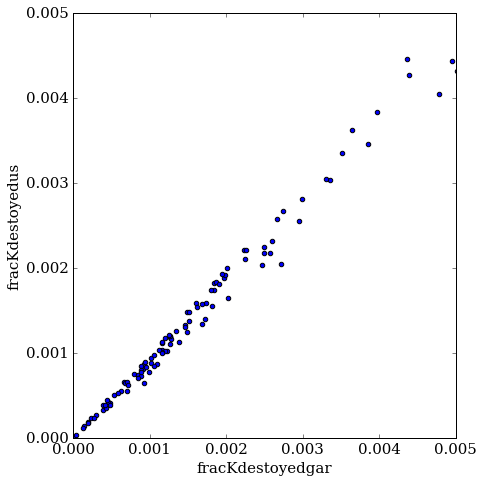

In [43]:
results["fracKdestoyedus"] =  results.dKtot/(results.gdp_pc_pp*results["pop"]/results.avg_prod_k)

results["fracKdestoyedgar"] =average_over_rp(pd.read_csv("intermediate/frac_value_destroyed_gar.csv").set_index(["country","hazard","rp"])).sum(level="country").squeeze()

results.plot.scatter(x="fracKdestoyedgar", y="fracKdestoyedus", figsize=(7,7))
plt.xlim(0,0.005)
plt.ylim(0,0.005)
makedirs("img",exist_ok=True)
savefig("img/gar_dkk_vs_us_dkk")

# export table

In [21]:
a=results.copy()

a["v"] = pd.read_csv("inputs/v_pr_fromPAGER_shaved_GAR.csv", index_col="country").v


to_output = ['gdp_pc_pp', 'pop',"v","fa","resilience","risk","risk_to_assets"]
a=a[to_output]

a["pop"] = a["pop"]/1e6

a["fa_in_gdp"] =  results["fa"]/ results["avg_prod_k"]

a.to_csv("intermediate/main_results.csv")


a.loc[:,["fa","fa_in_gdp","v","resilience","risk", "risk_to_assets"]]=100*a[["fa","fa_in_gdp","v","resilience","risk","risk_to_assets"]]
desc=pd.read_csv("inputs/inputs_info.csv").set_index('key')["descriptor"]
a=a.rename(columns=desc).dropna()
a.to_excel("intermediate/results.xlsx")
a.head()


,GDP per capita,Population,Vulnerability,Exposure (percent of the population),Resilience,Risk to welfare,Risk to assets,Exposure (percent of GDP)
country,,,,,,,,
Albania,9960.940726,2.897366,38.234225,0.481400,69.007030,1.431156,0.987598,2.598232
Angola,7488.011760,21.471618,60.540000,0.154274,31.208563,0.477733,0.149094,0.356786
Argentina,18087.196262,41.446246,41.111968,0.308703,56.729170,0.775769,0.440087,1.145254
Armenia,7526.836419,2.976566,24.298125,1.131023,70.691501,1.029256,0.727596,3.084364
Australia,42834.016760,23.129300,54.994642,0.129016,72.296851,0.280609,0.202872,0.471544


## export table for Brad's appendix of results

In [22]:
from fancy_round import fancy_round

In [23]:
export = pd.DataFrame()

In [24]:
# a["label_asset"]= "Risk to assets "+
export["Assets"]=(a["Risk to assets"]/100*a["GDP per capita"]*a["Population"]).map(lambda x:"Risk to assets: ${:,} million ".format(fancy_round(x)))+(a["Risk to assets"]).map(lambda x:"({:,}% of GDP)".format(fancy_round(x)))
export["Resilience"] = a["Resilience"].map(lambda x:"Socio-economic Resilience: {:,}%".format(fancy_round(x)))
export["Well-being"]=(a["Risk to welfare"]/100*a["GDP per capita"]*a["Population"]).map(lambda x:"Risk to well-being: ${:,} million ".format(fancy_round(x)))+(a["Risk to welfare"]).map(lambda x:"({:,}% of GDP)".format(fancy_round(x)))
export.to_csv("results/export_table_asset_resi_wellfare_labels_for_brad.csv")
export.sample(5)

,Assets,Resilience,Well-being
country,,,
Indonesia,"Risk to assets: $7,700 million (0.33% of GDP)",Socio-economic Resilience: 69%,"Risk to well-being: $11,000 million (0.49% of ..."
"Egypt, Arab Rep.",Risk to assets: $750 million (0.09% of GDP),Socio-economic Resilience: 58%,"Risk to well-being: $1,300 million (0.15% of GDP)"
Kazakhstan,"Risk to assets: $1,000 million (0.27% of GDP)",Socio-economic Resilience: 62%,"Risk to well-being: $1,600 million (0.43% of GDP)"
Philippines,"Risk to assets: $28,000 million (4.5% of GDP)",Socio-economic Resilience: 69%,"Risk to well-being: $41,000 million (6.5% of GDP)"
Moldova,Risk to assets: $150 million (0.9% of GDP),Socio-economic Resilience: 75%,Risk to well-being: $190 million (1.2% of GDP)


# report countries per region and lending group

In [25]:
wb_countries = pd.read_csv("inputs/iso3_to_wb_name.csv")

In [26]:

groups = pd.read_csv("inputs/income_groups.csv",header =4,index_col=2).replace({"ROM":"ROU","ZAR":"COD"})  #they used old iso3 country for Zair (Congo) and Romania
groups= groups[["Code","Region","Income group","Lending category","Other"]]
groups.dropna(axis=0,how="all",inplace=True);
groups.rename(columns={"Other":"HIPC"},inplace=True)
groups['HIPC'].fillna('',inplace=True)
groups["Lending category"].replace("..","",inplace=True)

groups =groups.ix[wb_countries.country.values]


#counts IDA and non-IDA countries for which we have the data
groups.ix[results.dropna().index][["Lending category"]].to_excel("lending_categories.xlsx")
print("our sample\n", groups.ix[results.dropna().index]["Lending category"].value_counts())

print("\ntotal\n", groups["Lending category"].value_counts())

#Build excel file reporting countries for which we have or have not data
groups["has all data"]=0
groups["has all data"]=(np.sign(results.risk))
groups["has all data"].fillna(0,inplace=True)

#Bigger report including missing data
# groups["missing_data"]=report["missing_data"]
# groups["missing_data"].fillna("",inplace=True)
groups.head()


print("\nFraction of COUNTRIES covered\n")
print(groups.groupby("Lending category")["has all data"].mean())
print(" ")
print(groups.groupby("Region")["has all data"].mean())
print(" ")
print(groups.groupby("Income group")["has all data"].mean())
print("global")
print((groups[["has all data"]].mean()))



#population
groups["pop"]=pd.read_csv("inputs/wb_data.csv",index_col="country")["pop"]
print("\n===========\nFraction of POPULATION covered\n")
print(groups.groupby("Lending category")[["has all data","pop"]].apply(lambda s: s.prod(axis=1)/s["pop"].sum()).sum(level=0))
print(" ")
print(groups.groupby("Region")[["has all data","pop"]].apply(lambda s: s.prod(axis=1)/s["pop"].sum()).sum(level=0))
print(" ")
print(groups.groupby("Income group")[["has all data","pop"]].apply(lambda s: s.prod(axis=1)/s["pop"].sum()).sum(level=0))
print("global")
print((groups[["has all data","pop"]].prod(axis=1)/groups["pop"].sum()).sum())


#global



groups.to_excel("have_and_have_nots.xlsx", encoding="utf-8")
groups.to_csv("have_and_have_nots.csv", encoding="utf-8")

our sample
 IBRD     50
IDA      33
         24
Blend    10
Name: Lending category, dtype: int64

total
          68
IBRD     67
IDA      56
Blend    17
Name: Lending category, dtype: int64

Fraction of COUNTRIES covered

Lending category
         0.352941
Blend    0.588235
IBRD     0.746269
IDA      0.589286
Name: has all data, dtype: float64
 
Region
East Asia & Pacific           0.305556
Europe & Central Asia         0.727273
Latin America & Caribbean     0.450000
Middle East & North Africa    0.428571
North America                 0.666667
South Asia                    0.625000
Sub-Saharan Africa            0.711111
Name: has all data, dtype: float64
 
Income group
High income: OECD       0.750000
High income: nonOECD    0.155556
Low income              0.612903
Lower middle income     0.744681
Upper middle income     0.603774
Name: has all data, dtype: float64
global
has all data    0.536697
dtype: float64

Fraction of POPULATION covered



TypeError: Series.name must be a hashable type

In [27]:
groups.query("Region=='North America'")

,Code,Region,Income group,Lending category,HIPC,has all data,pop
Economy,,,,,,,
Bermuda,BMU,North America,High income: nonOECD,,,0.0,65235.0
Canada,CAN,North America,High income: OECD,,,1.0,35851774.0
United States,USA,North America,High income: OECD,,,1.0,321418820.0


In [28]:
groups.ix["Mexico"]

Code                                      MEX
Region              Latin America & Caribbean
Income group              Upper middle income
Lending category                         IBRD
HIPC                                         
has all data                                1
pop                               1.27017e+08
Name: Mexico, dtype: object

In [ ]:
(100*results.dK/results.k).replace(0,np.nan).dropna().sort_values().plot.bar(figsize=(20,6))
plt.ylabel("E[dk]/k (%)")

In [ ]:
reldk_agv = average_over_rp(pd.read_csv("intermediate/frac_value_destroyed_gar.csv", index_col=[0,1,2]))
reldk_agv.columns=["gar"]

reldk_agv =reldk_agv.swaplevel(0,1).sort_index().assign(model=np.nan)

reldk_agv.head()

for h in hazard_ratios.reset_index("hazard").hazard.unique():
#     args = dict(hazard_ratios = hazard_ratios)
    args = dict(hazard_ratios = hazard_ratios.swaplevel("country","hazard").ix[h])

    results =compute_resilience(macro,cat_info,**args)
    reldk_agv["model"].update(pd.concat([results.dK/cat_info[["k","n"]].prod(axis=1, skipna=False).sum(level="country")], keys=[h]))

    

In [ ]:

for out in  ["resilience", "risk_to_assets"]:
    a = compute_resilience(macro,cat_info,)[out]
    b= compute_resilience(macro,cat_info, hazard_ratios=hazard_ratios)[out]
    c= compute_resilience(macro,cat_info, hazard_ratios=hazard_ratios.unstack("hazard").swaplevel(0,1,axis=1)["flood"])[out]
    d= compute_resilience(macro,cat_info, hazard_ratios=hazard_ratios.unstack("rp").swaplevel(0,1,axis=1)[20])[out]

    plt.figure(figsize=(6,6))
    plt.scatter(x=a,y=b,  s=50,clip_on=False, c="blue",alpha=0.5, )
    plt.scatter(x=a,y=c, alpha=0.5, s=50,clip_on=False, color="green")
    plt.scatter(x=a,y=d, alpha=0.5, s=50,clip_on=False, c="red")

    plt.legend(["All hazard data", "Only river", "only rp=20"], loc="best")
    plt.xlabel("no hazard")
    plt.ylabel("")
    plt.xlim(0,)
    plt.ylim(0,)


